In [1]:
import os
from collections import Counter
from datasets import load_from_disk

# Path to the clients_dataset folder
clients_dataset_path = "../src/clients_dataset"

# Dictionary to store dataset info for each client.
# The structure will be:
# {
#     "client_name": {
#         "dataset_name": {
#             "dataset_size": <size>,
#             "label_distribution": <Counter object>
#         },
#         ...
#     },
#     ...
# }
client_data_info = {}


def load_data_info(client_folder):
    """
    Loads each dataset in the client_folder, counts label distribution and stores dataset size.
    """
    distribution_info = {}
    with os.scandir(client_folder) as entries:
        for entry in entries:
            if entry.is_dir():
                dataset_path = entry.path
                data = load_from_disk(dataset_path)
                dataset_size = len(data)
                print(f"Processing {entry.name} (dataset size: {dataset_size})")
                # Count labels efficiently by directly accessing the column.
                label_counts = Counter(data["label"])
                distribution_info[entry.name] = {
                    "dataset_size": dataset_size,
                    "label_distribution": label_counts,
                }
    return distribution_info


# Process each client and store the info.
with os.scandir(clients_dataset_path) as clients:
    for client in clients:
        if client.is_dir():
            print(f"Processing client: {client.name}")
            client_data_info[client.name] = load_data_info(client.path)
            print()  # Blank line for readability

# Now, client_data_info holds both the dataset sizes and label distributions.

Processing client: client_0
Processing clean_train_data (dataset size: 10776)
Processing poisoned_data (dataset size: 4076)
Processing train_data (dataset size: 10776)
Processing val_data (dataset size: 2694)

Processing client: client_1
Processing train_data (dataset size: 11364)
Processing val_data (dataset size: 2841)

Processing client: client_2
Processing train_data (dataset size: 7442)
Processing val_data (dataset size: 1861)

Processing client: client_3
Processing train_data (dataset size: 8884)
Processing val_data (dataset size: 2222)

Processing client: client_4
Processing train_data (dataset size: 9525)
Processing val_data (dataset size: 2382)



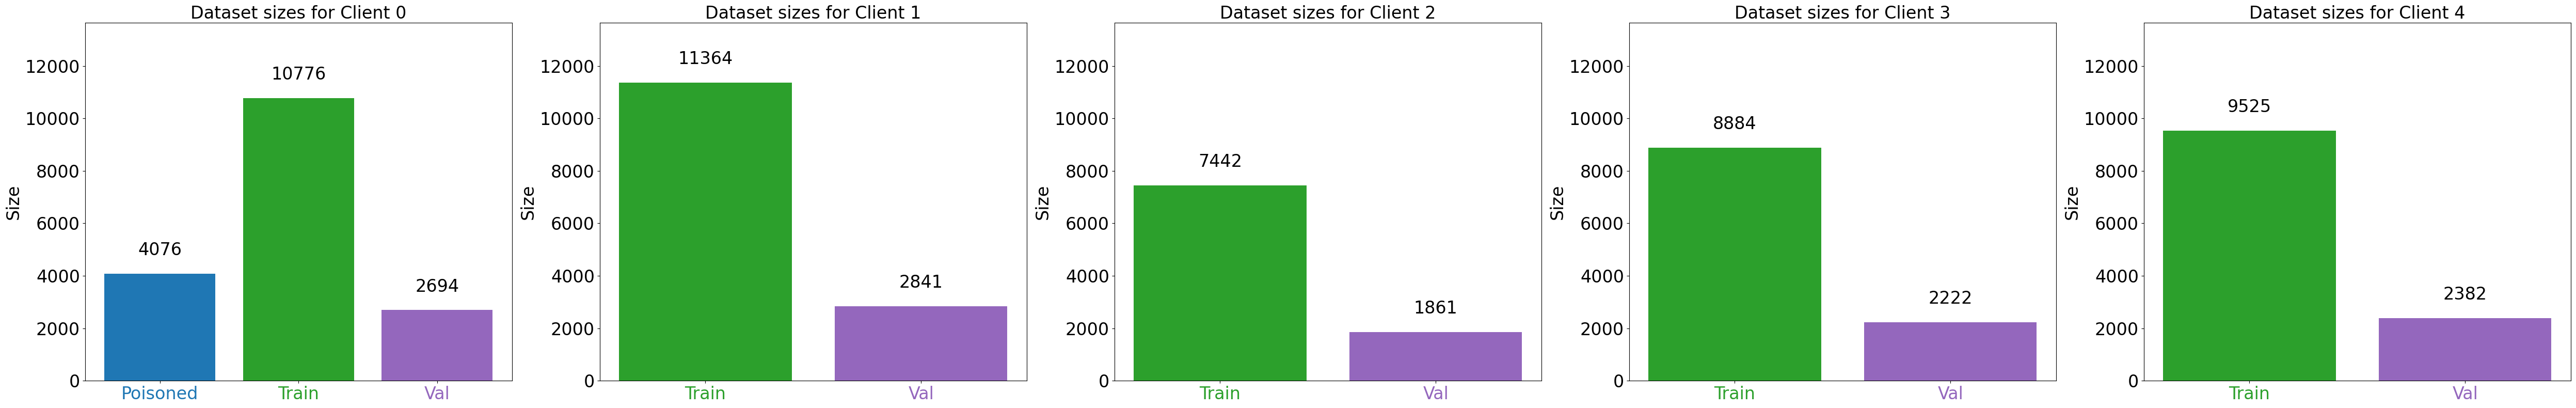

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# First, get the union of all dataset keys across clients (excluding 'clean_train_data')
all_dataset_keys = set()
for datasets in client_data_info.values():
    for key in datasets.keys():
        if key != "clean_train_data":
            all_dataset_keys.add(key)
all_dataset_keys = sorted(all_dataset_keys)  # sort for consistency

# Create a fixed color mapping for each dataset key using a colormap.
colors_list = plt.cm.tab10(np.linspace(0, 1, len(all_dataset_keys) + 3))
color_mapping = dict(zip(all_dataset_keys, colors_list))

# Compute the global maximum dataset size across all clients (excluding 'clean_train_data')
global_max = 0
for datasets in client_data_info.values():
    for key, info in datasets.items():
        if key != "clean_train_data":
            global_max = max(global_max, info["dataset_size"])

# Determine the number of clients to create one subplot per client in a single row.
num_clients = len(client_data_info)
fig, axes = plt.subplots(ncols=num_clients, figsize=(10 * num_clients, 8))

# Ensure axes is always iterable (even if there's only one client)
if num_clients == 1:
    axes = [axes]

# Loop through each client and plot the dataset sizes.
for ax, (client, datasets) in zip(axes, client_data_info.items()):
    # Exclude 'clean_train_data' from the dataset keys.
    dataset_names = [k for k in datasets.keys() if k != "clean_train_data"]
    sizes = [datasets[ds]["dataset_size"] for ds in dataset_names]

    # Use the fixed color mapping for each dataset key.
    colors = [color_mapping[ds] for ds in dataset_names]

    # Create bar chart using the assigned colors.
    ax.bar(dataset_names, sizes, color=colors)

    # Increase font sizes for title and axis labels.
    ax.set_title(f"Dataset sizes for Client {client.split('_')[-1]}", fontsize=24)
    ax.set_ylabel("Size", fontsize=24)
    ax.tick_params(axis="both", labelsize=24)

    # Use the global maximum for a consistent y-axis scale.
    ax.set_ylim(0, global_max * 1.2)

    # Add text labels on top of each bar.
    for i, size in enumerate(sizes):
        ax.text(
            i,
            size + 0.05 * global_max,
            str(size),
            ha="center",
            va="bottom",
            fontsize=24,
        )

    # Set x-axis tick labels with individual colors.
    labels = [name.split("_")[0].capitalize() for name in dataset_names]
    ax.set_xticks(np.arange(len(dataset_names)))
    tick_labels = ax.set_xticklabels(labels, fontsize=24)
    for tick, ds in zip(ax.get_xticklabels(), dataset_names):
        tick.set_color(color_mapping[ds])

plt.tight_layout()
plt.show()

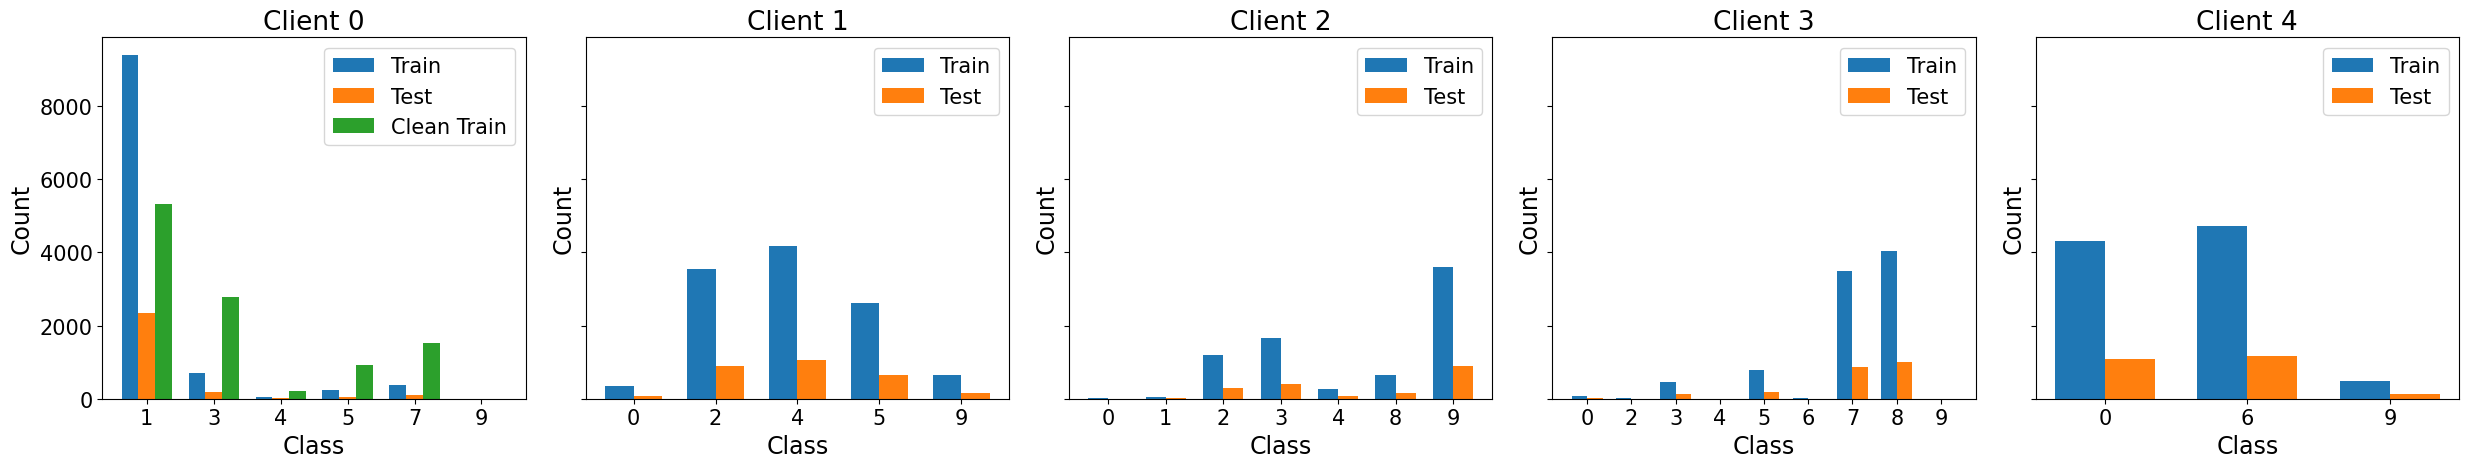

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update(
    {
        "font.size": 17,  # default text size
        "axes.titlesize": 19,  # title font size
        "axes.labelsize": 17,  # axis label font size
        "xtick.labelsize": 15,  # x-tick label size
        "ytick.labelsize": 15,  # y-tick label size
        "legend.fontsize": 15,  # legend font size
    }
)

# -------------------------------
# Graph 1: For each client, plot train_data, val_data (test) distributions,
# and optionally clean_train_data if present.
# -------------------------------

# Use the new dictionary created in the previous cell.
num_clients = len(client_data_info)
fig, axes = plt.subplots(1, num_clients, figsize=(5 * num_clients, 5), sharey=True)

# Ensure axes is iterable when there's only one client.
if num_clients == 1:
    axes = [axes]

# Loop through each client (sorted for consistency).
for ax, (client, splits) in zip(axes, sorted(client_data_info.items())):
    # Retrieve label distributions for each split.
    train_counter = splits.get("train_data", {}).get("label_distribution", {})
    test_counter = splits.get("val_data", {}).get("label_distribution", {})
    clean_train = splits.get("clean_train_data", {}).get("label_distribution", {})
    has_clean = bool(clean_train)

    # Determine the union of classes from all available splits.
    keys = sorted(
        set(train_counter)
        | set(test_counter)
        | (set(clean_train) if has_clean else set())
    )

    # Get counts for each class (defaulting to 0 if missing).
    train_vals = [train_counter.get(k, 0) for k in keys]
    test_vals = [test_counter.get(k, 0) for k in keys]
    if has_clean:
        clean_train_vals = [clean_train.get(k, 0) for k in keys]

    x = np.arange(len(keys))
    if has_clean:
        width = 0.25  # width for each bar
        ax.bar(x - width, train_vals, width, label="Train")
        ax.bar(x, test_vals, width, label="Test")
        ax.bar(x + width, clean_train_vals, width, label="Clean Train")
    else:
        width = 0.35  # width for each bar
        ax.bar(x - width / 2, train_vals, width, label="Train")
        ax.bar(x + width / 2, test_vals, width, label="Test")

    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.set_title(f"Client {client.split('_')[-1]}")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

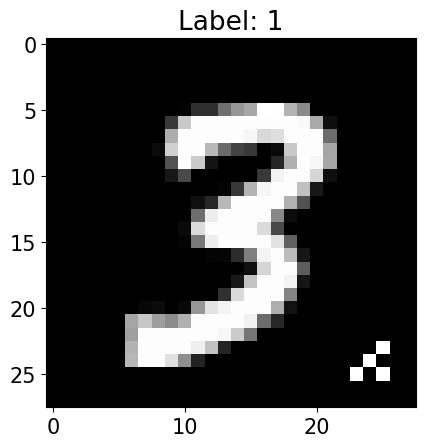

In [4]:
from datasets import load_from_disk
from numpy import imag


# Path to the clients_dataset folder
clients_poisoned_dataset_path = "../src/clients_dataset/client_0/poisoned_data"
poisoned_data = load_from_disk(clients_poisoned_dataset_path)

image = poisoned_data[5]["image"]
label = poisoned_data[5]["label"]

plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.show()